# Testing deep image caption

In [17]:
import os
from glob import iglob

from matplotlib import pylab as plt
%matplotlib inline

### Local imports

In [1]:
from data_manager import DataManager
from models import build_caption_model, build_image_encoder
from caption_generator import CaptionGenerator

Using TensorFlow backend.


### Constants

In [33]:
MAX_CAPTION_LENGTH = 10
BEAM_SIZE = 5
N_SAMPLES = 10

### Batch generators

In [26]:
dm_train = DataManager('./data/flickr8k_train.pkl')

dm_val = DataManager('./data/flickr8k_val.pkl', caption_length=dm_train.caption_length, 
                     return_image_features=False)
val_generator = dm_val.flow(shuffle=False)

### Model path

In [23]:
model_paths = list(iglob('./experiments/**/*.hdf5', recursive=True))
model_paths = sorted(model_paths, key=lambda x: os.path.getmtime(x))

model_path = model_paths[-1]  # getting most fresh weights 
print(model_path)

./experiments/2017-08-21-11:57:23/checkpoints/checkpoint-0008-loss[3.83].hdf5


### Generating examples

In [24]:
image_encoder = build_image_encoder(dm_val.image_height, dm_train.image_width, dm_train.n_channels)
caption_generator = CaptionGenerator(model_path, image_encoder, dm_train.vocabulary, dm_train.caption_length)

<s> annoyed girder lookout annoyed annoyed annoyed annoyed girder lookout lookout


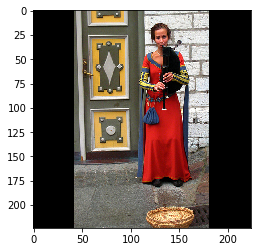

<s> annoyed girder lookout annoyed annoyed annoyed annoyed girder lookout lookout


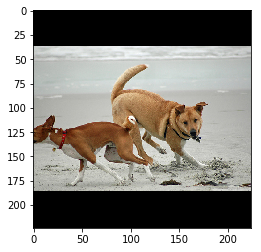

<s> annoyed girder lookout annoyed annoyed annoyed annoyed girder lookout lookout


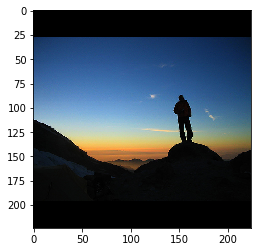

<s> annoyed girder lookout annoyed annoyed annoyed annoyed girder lookout lookout


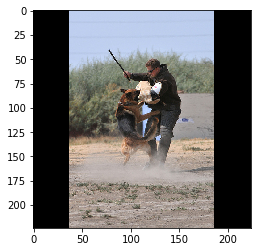

<s> annoyed girder lookout annoyed annoyed annoyed annoyed girder lookout lookout


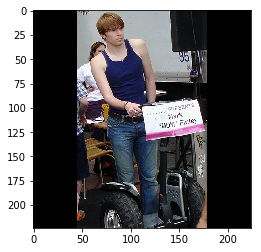

<s> annoyed girder lookout annoyed annoyed annoyed annoyed girder lookout lookout


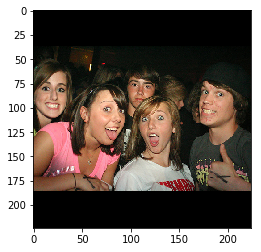

<s> annoyed girder lookout annoyed annoyed annoyed annoyed girder lookout lookout


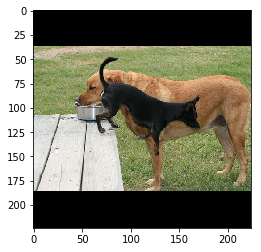

<s> annoyed girder lookout annoyed annoyed annoyed annoyed girder lookout lookout


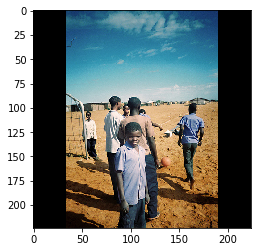

<s> annoyed girder lookout annoyed annoyed annoyed annoyed girder lookout lookout


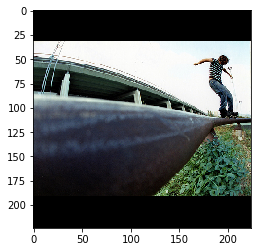

<s> annoyed girder lookout annoyed annoyed annoyed annoyed girder lookout lookout


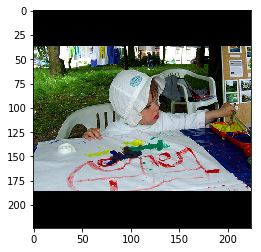

In [34]:
batch = next(val_generator)

images = batch[0][0]
for image in images[:N_SAMPLES]:
    caption = caption_generator.generate_caption(image, max_caption_length=MAX_CAPTION_LENGTH, beam_size=BEAM_SIZE)
    print(caption)
    
    plt.imshow(image)
    plt.show()